<a href="https://colab.research.google.com/github/mengjie-gao/disk-failure-prediction/blob/main/10Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


PyTorch version: 2.8.0+cu126
CUDA available: True


In [ ]:
from google.colab import drive

# Load Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
    roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import pandas as pd

# **DL**

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Load data
df = pd.read_csv('/content/drive/MyDrive/diskdata/dl_sequences.csv')
df.fillna(0, inplace=True)

# Extract tags and information
metadata_cols = ['disk_id', 'model', 'date']
label_col = 'label'
y = df[label_col].values
metadata = df[metadata_cols]

X_raw = df.drop(columns=metadata_cols + [label_col])

# Automatically infer the time step T and the feature number F
feature_names = X_raw.columns.tolist()
prefixes = sorted(set(col.split('_t')[0] for col in feature_names))
F = len(prefixes)
T = len(feature_names) // F

# Consistency check
expected_feature_dim = T * F
if X_raw.shape[1] != expected_feature_dim:
    raise ValueError(f"The number of feature columns should be {expected_feature_dim}，but it is actually {X_raw.shape[1]}，please check the data format")

print(f"Infer the number of time steps T = {T}，The number of features at each step F = {F}")
print("Still contain NaN or not：", X_raw.isna().any().any())
print(f"Original feature dimension: {X_raw.shape}")

# Standardize and convert to 3D
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N = len(X_scaled)
X = X_scaled.reshape(N, T, F)

print("LSTM/CNN input X shape:", X.shape)
print(" y shape:", y.shape)

np.save('/content/drive/MyDrive/diskdata/X_lstm.npy', X)
np.save('/content/drive/MyDrive/diskdata/y_lstm.npy', y)

np.save('/content/drive/MyDrive/diskdata/dates.npy', metadata['date'].values.astype('datetime64[D]'))
np.save('/content/drive/MyDrive/diskdata/disk_ids.npy', metadata['disk_id'].values.astype(str))

print("Saved: X_lstm.npy, y_lstm.npy, dates.npy, disk_ids.npy")

Infer the number of time steps T = 10，The number of features at each step F = 7
Still contain NaN or not： False
Original feature dimension: (22506, 70)
LSTM/CNN input X shape: (22506, 10, 7)
 y shape: (22506,)
Saved: X_lstm.npy, y_lstm.npy, dates.npy, disk_ids.npy


# CNN Model

Final Split -> Train=14109, Val=3516, Test=4524
y_train bincount: [11479  2630]
y_val   bincount: [2898  618]
y_test  bincount: [1436 3088]
Epoch 01 | Train Loss 0.1867 Acc 0.9257 | Val Loss 0.0552 Acc 0.9684 F1 0.9158
Epoch 02 | Train Loss 0.0957 Acc 0.9708 | Val Loss 0.0483 Acc 0.9730 F1 0.9270
Epoch 03 | Train Loss 0.0906 Acc 0.9721 | Val Loss 0.0427 Acc 0.9758 F1 0.9342
Epoch 04 | Train Loss 0.0915 Acc 0.9709 | Val Loss 0.0459 Acc 0.9747 F1 0.9313
Epoch 05 | Train Loss 0.0935 Acc 0.9741 | Val Loss 0.0674 Acc 0.9511 F1 0.8761
Epoch 06 | Train Loss 0.0895 Acc 0.9727 | Val Loss 0.0466 Acc 0.9670 F1 0.9124
Epoch 07 | Train Loss 0.0878 Acc 0.9734 | Val Loss 0.0463 Acc 0.9707 F1 0.9213
Epoch 08 | Train Loss 0.0890 Acc 0.9724 | Val Loss 0.0540 Acc 0.9536 F1 0.8818
Epoch 09 | Train Loss 0.0887 Acc 0.9727 | Val Loss 0.0480 Acc 0.9667 F1 0.9117
Early stopping at epoch 9, best val F1 = 0.9342

Final Test Classification Report:
               precision    recall  f1-score   support

          

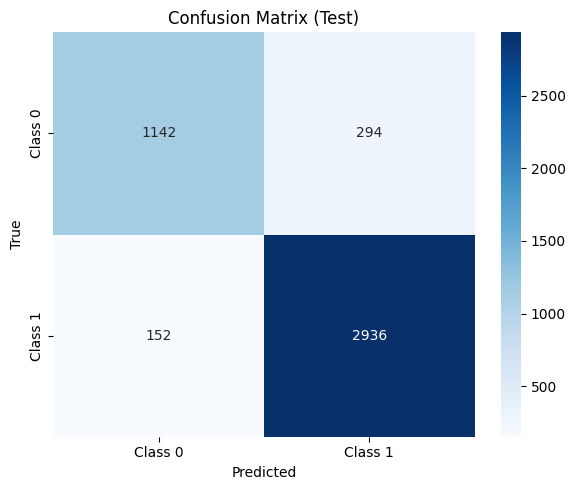

ROC-AUC: 0.9669
Average Precision (AP): 0.9851
Positive class baseline: 0.6826


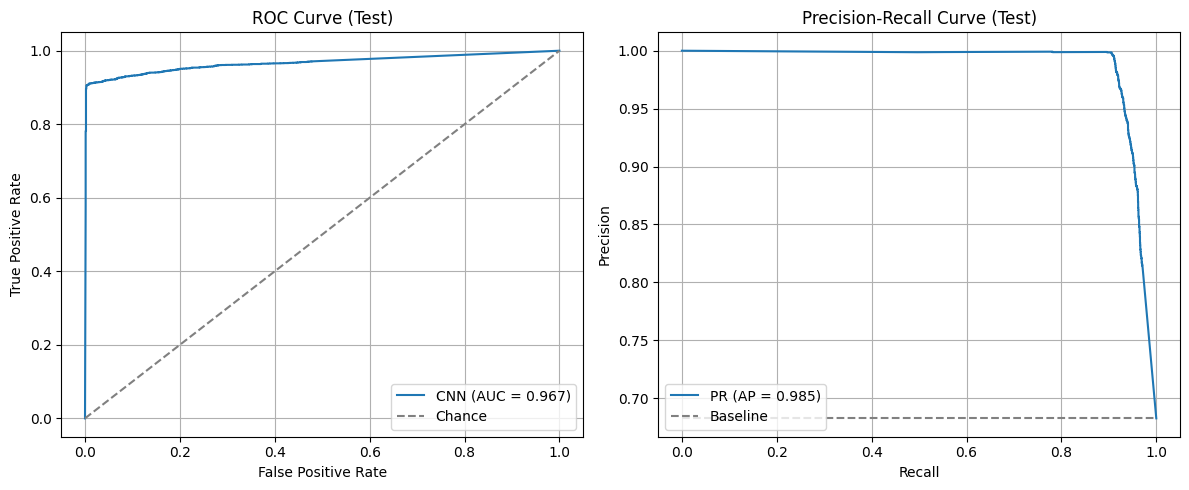

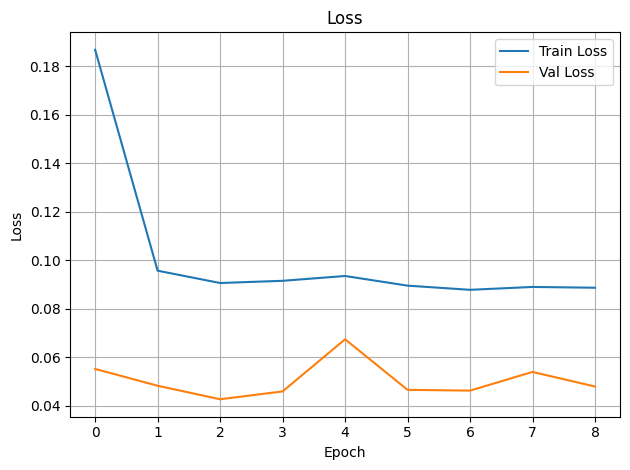

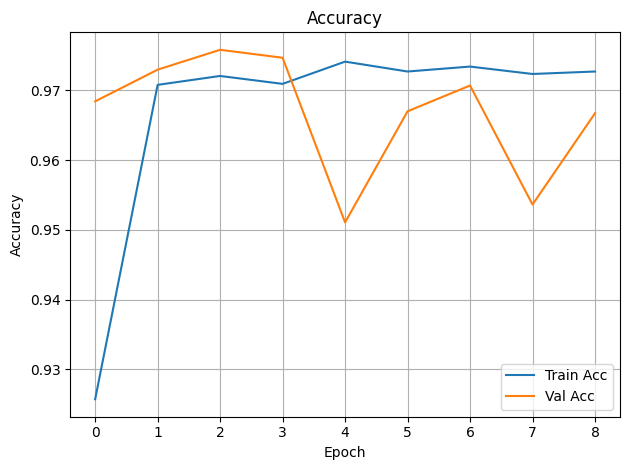

Shared disk_ids (should be 0): 0


In [ ]:
#Load
X = np.load('/content/drive/MyDrive/diskdata/X_lstm.npy')   # (N, T, F)
y = np.load('/content/drive/MyDrive/diskdata/y_lstm.npy')
dates = np.load('/content/drive/MyDrive/diskdata/dates.npy').astype('datetime64[D]')
disk_ids = np.load('/content/drive/MyDrive/diskdata/disk_ids.npy').astype(str)
assert len(X)==len(y)==len(dates)==len(disk_ids)

# Time division + GAP + device isolation
TEST_SIZE     = 0.2
VAL_SIZE      = 0.20        #Proportion of validation set
USE_TIME_VAL  = True
GAP_DAYS      = max(X.shape[1], 7)

ts = dates.astype('datetime64[s]').astype('int64')
cutoff = np.datetime64(int(np.quantile(ts, 1-TEST_SIZE)), 's')
gap    = np.timedelta64(GAP_DAYS, 'D')

train_mask_time = dates < (cutoff - gap)
test_mask       = dates >= cutoff

# Device isolation: Remove discs that have appeared in the test set from the training candidates
test_disks = set(disk_ids[test_mask])
train_mask_device_safe = np.array(
    [m and (disk_ids[i] not in test_disks) for i, m in enumerate(train_mask_time)]
)

# Cut the verification set again in units of "disks"
idx_all  = np.where(train_mask_device_safe)[0]
disk_tr  = disk_ids[idx_all]
dates_tr = dates[idx_all]
y_tr     = y[idx_all]

uniq = np.unique(disk_tr)
last_dt = np.empty(len(uniq), dtype='datetime64[D]')
is_pos_disk = np.zeros(len(uniq), dtype=int)
for i, d in enumerate(uniq):
    m = (disk_tr == d)
    last_dt[i]     = dates_tr[m].max()
    is_pos_disk[i] = int(y_tr[m].max())

pos_disks = uniq[is_pos_disk == 1]
neg_disks = uniq[is_pos_disk == 0]
last_dt_map = {d: last_dt[i] for i, d in enumerate(uniq)}

def pick_val_disks(disks, last_dt_map, frac, use_time=True, rng_seed=42):
    if len(disks) == 0: return set()
    k = max(1, int(np.ceil(len(disks) * frac)))
    if use_time:
        order = np.argsort([last_dt_map[d] for d in disks])
        chosen = [disks[i] for i in order[-k:]]
    else:
        rng = np.random.default_rng(rng_seed)
        chosen = rng.choice(disks, size=k, replace=False)
    return set(chosen)

val_pos = pick_val_disks(pos_disks, last_dt_map, VAL_SIZE, use_time=USE_TIME_VAL)
val_neg = pick_val_disks(neg_disks, last_dt_map, VAL_SIZE, use_time=USE_TIME_VAL)
val_disks = val_pos | val_neg


is_val_disk   = np.array([d in val_disks for d in disk_tr])
is_train_disk = ~is_val_disk

val_mask_final   = np.zeros_like(test_mask, dtype=bool)
train_mask_final = np.zeros_like(test_mask, dtype=bool)
val_mask_final[idx_all[is_val_disk]]     = True
train_mask_final[idx_all[is_train_disk]] = True

assert len(set(disk_ids[train_mask_final]) & set(disk_ids[val_mask_final])) == 0, "Train/Val Equipment leakage！"
assert len(set(disk_ids[train_mask_final]) & set(disk_ids[test_mask])) == 0, "Train/Test Equipment leakage！"
assert len(set(disk_ids[val_mask_final])   & set(disk_ids[test_mask])) == 0, "Val/Test Equipment leakage！"

X_train, y_train = X[train_mask_final], y[train_mask_final]
X_val,   y_val   = X[val_mask_final],   y[val_mask_final]
X_test,  y_test  = X[test_mask],        y[test_mask]

print(f"Final Split -> Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")
print('y_train bincount:', np.bincount(y_train))
print('y_val   bincount:', np.bincount(y_val))
print('y_test  bincount:', np.bincount(y_test))

# Dataset & Loader
class DiskDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return torch.tensor(self.X[i], dtype=torch.float32), torch.tensor(self.y[i], dtype=torch.long)

train_loader = DataLoader(DiskDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader   = DataLoader(DiskDataset(X_val,   y_val),   batch_size=256, shuffle=False)
test_loader  = DataLoader(DiskDataset(X_test,  y_test),  batch_size=256, shuffle=False)

# CNN Model
T, F = X_train.shape[1], X_train.shape[2]

class CNNModel(nn.Module):
    def __init__(self, in_ch, seq_len):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=in_ch, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        out_len = max(seq_len // 4, 1)
        self.fc1 = nn.Linear(64 * out_len, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 2)
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, F, T)
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.reshape(x.size(0), -1)
        x = self.dropout(self.fc1(x))
        return self.fc2(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel(in_ch=F, seq_len=T).to(device)

counts = np.bincount(y_train)
class_w = (counts.sum() / (counts + 1e-8)).astype(np.float32)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_w, device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
clip_norm = 1.0

EPOCHS   = 40
patience = 6
best_f1, best_state, wait = -1, None, 0

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for ep in range(1, EPOCHS+1):
    # ---- Train ----
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()
        loss_sum += loss.item()
        pred = logits.argmax(1)
        correct += (pred==yb).sum().item()
        total   += yb.size(0)
    train_losses.append(loss_sum/len(train_loader))
    train_accs.append(correct/total)

    # ---- Val ----
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    v_pred, v_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            v_loss += loss.item()
            pred = logits.argmax(1)
            v_correct += (pred==yb).sum().item()
            v_total   += yb.size(0)
            v_pred.extend(pred.cpu().numpy())
            v_true.extend(yb.cpu().numpy())
    val_losses.append(v_loss/len(val_loader))
    val_acc = v_correct / v_total
    val_accs.append(val_acc)
    val_f1 = f1_score(v_true, v_pred, average='binary', pos_label=1)

    print(f"Epoch {ep:02d} | Train Loss {train_losses[-1]:.4f} Acc {train_accs[-1]:.4f} "
          f"| Val Loss {val_losses[-1]:.4f} Acc {val_acc:.4f} F1 {val_f1:.4f}")

    # Early stopping
    if val_f1 > best_f1 + 1e-4:
        best_f1, best_state, wait = val_f1, {k:v.cpu().clone() for k,v in model.state_dict().items()}, 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {ep}, best val F1 = {best_f1:.4f}")
            break

if best_state is not None:
    model.load_state_dict(best_state)

# Test
model.eval()
all_preds, all_labels = [], []
all_probs = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)[:, 1]
        pred = logits.argmax(1).cpu().numpy()

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(pred)
        all_labels.extend(yb.numpy())

print("\nFinal Test Classification Report:\n", classification_report(all_labels, all_preds))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0","Class 1"], yticklabels=["Class 0","Class 1"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Test)")
plt.tight_layout(); plt.show()
# ROC & PR
y_test_np = np.asarray(all_labels)
y_prob_np = np.asarray(all_probs)

# ROC
fpr, tpr, _ = roc_curve(y_test_np, y_prob_np)
roc_auc = auc(fpr, tpr)

# PR
precision, recall, _ = precision_recall_curve(y_test_np, y_prob_np)
ap = average_precision_score(y_test_np, y_prob_np)
pos_rate = (y_test_np == 1).mean()

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision (AP): {ap:.4f}")
print(f"Positive class baseline: {pos_rate:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- ROC ---
axes[0].plot(fpr, tpr, label=f'CNN (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve (Test)')
axes[0].legend()
axes[0].grid(True)

# --- PR ---
axes[1].plot(recall, precision, label=f'PR (AP = {ap:.3f})')
axes[1].hlines(pos_rate, 0, 1, colors='gray', linestyles='--', label='Baseline')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve (Test)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
# Training & validation curve
plt.figure(); plt.plot(train_losses, label="Train Loss"); plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(train_accs, label="Train Acc"); plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Final self-check for equipment leakage
shared = len(set(disk_ids[train_mask_final]) & set(disk_ids[test_mask]))
print("Shared disk_ids (should be 0):", shared)
assert shared == 0, f"Device leakage! shared disks = {shared}"


# LSTM Model

Final Split -> Train=14109, Val=3516, Test=4524
y_train bincount: [11479  2630]
y_val   bincount: [2898  618]
y_test  bincount: [1436 3088]
Epoch 01 | Train Loss 0.2542 Acc 0.9583 | Val Loss 0.0503 Acc 0.9755 F1 0.9322
Epoch 02 | Train Loss 0.1012 Acc 0.9755 | Val Loss 0.0605 Acc 0.9744 F1 0.9306
Epoch 03 | Train Loss 0.0982 Acc 0.9749 | Val Loss 0.0517 Acc 0.9747 F1 0.9313
Epoch 04 | Train Loss 0.0967 Acc 0.9746 | Val Loss 0.0483 Acc 0.9747 F1 0.9313
Epoch 05 | Train Loss 0.0937 Acc 0.9746 | Val Loss 0.0488 Acc 0.9741 F1 0.9298
Epoch 06 | Train Loss 0.0924 Acc 0.9751 | Val Loss 0.0458 Acc 0.9747 F1 0.9313
Epoch 07 | Train Loss 0.0913 Acc 0.9753 | Val Loss 0.0511 Acc 0.9704 F1 0.9206
Early stopping at epoch 7, best val F1 = 0.9322

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1436
           1       0.92      0.94      0.93      3088

    accuracy                           0.90      4524
   macro 

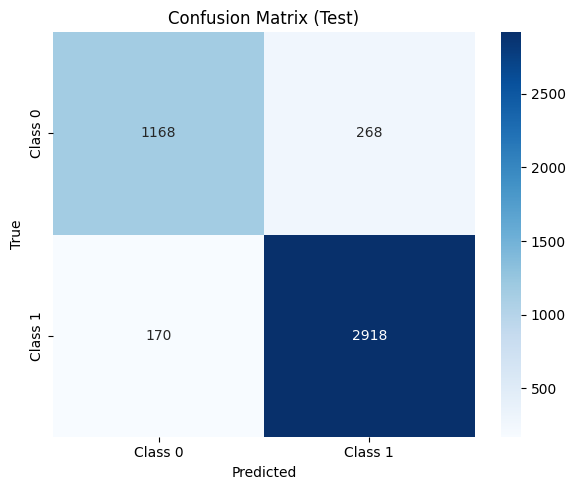

ROC-AUC: 0.9654
Average Precision (AP): 0.9850
Positive class baseline: 0.6826


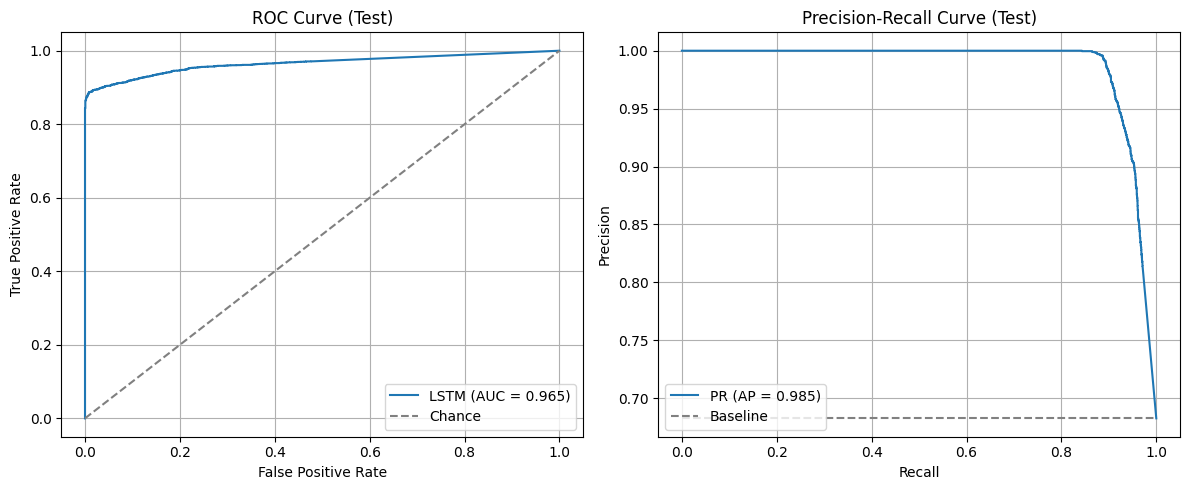

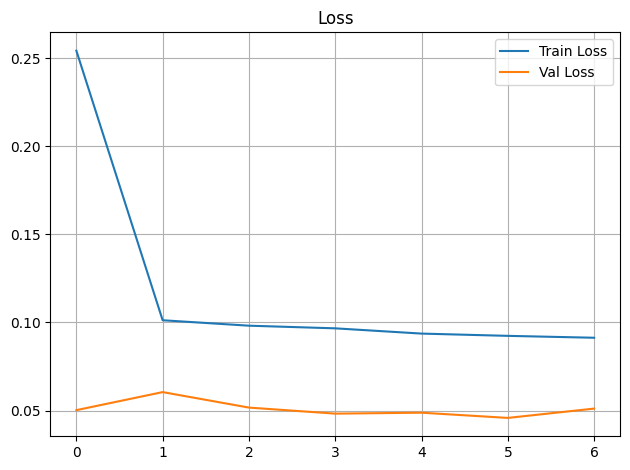

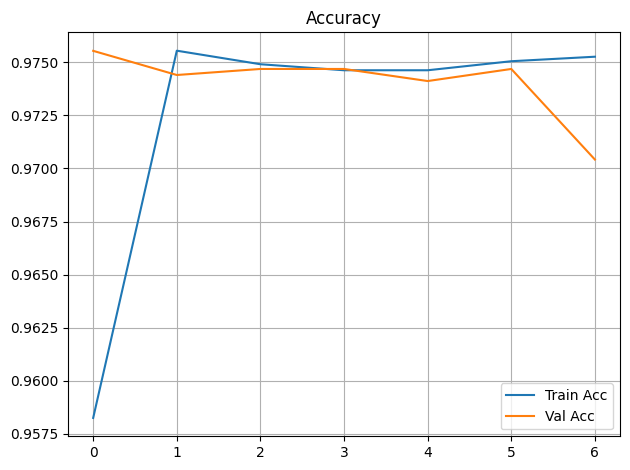

In [ ]:
# Load
X = np.load('/content/drive/MyDrive/diskdata/X_lstm.npy')   # (N, T, F)
y = np.load('/content/drive/MyDrive/diskdata/y_lstm.npy')
dates = np.load('/content/drive/MyDrive/diskdata/dates.npy').astype('datetime64[D]')
disk_ids = np.load('/content/drive/MyDrive/diskdata/disk_ids.npy').astype(str)
assert len(X)==len(y)==len(dates)==len(disk_ids)

# Time division + GAP + device isolation
TEST_SIZE = 0.2
VAL_SIZE  = 0.2         # Proportion of validation set
USE_TIME_VAL = True
GAP_DAYS = max(X.shape[1], 7)

ts = dates.astype('datetime64[s]').astype('int64')
cutoff = np.datetime64(int(np.quantile(ts, 1-TEST_SIZE)), 's')
gap = np.timedelta64(GAP_DAYS, 'D')

train_mask_time = dates < (cutoff - gap)
test_mask       = dates >= cutoff

# Remove the test disk from the training candidates
test_disks = set(disk_ids[test_mask])
train_mask_device_safe = np.array(
    [m and (disk_ids[i] not in test_disks) for i, m in enumerate(train_mask_time)]
)


VAL_SIZE = 0.20
USE_TIME_VAL = True

idx_all   = np.where(train_mask_device_safe)[0]
disk_tr   = disk_ids[idx_all]
dates_tr  = dates[idx_all]
y_tr      = y[idx_all]

uniq = np.unique(disk_tr)
last_dt = np.empty(len(uniq), dtype='datetime64[D]')
is_pos_disk = np.zeros(len(uniq), dtype=int)
for i, d in enumerate(uniq):
    m = (disk_tr == d)
    last_dt[i] = dates_tr[m].max()
    is_pos_disk[i] = int(y_tr[m].max())

pos_disks = uniq[is_pos_disk == 1]
neg_disks = uniq[is_pos_disk == 0]

def pick_val_disks(disks, last_dt_map, frac, use_time=True, rng_seed=42):
    if len(disks) == 0:
        return set()
    k = max(1, int(np.ceil(len(disks) * frac)))
    if use_time:
        order = np.argsort([last_dt_map[d] for d in disks])
        chosen = [disks[i] for i in order[-k:]]
    else:
        rng = np.random.default_rng(rng_seed)
        chosen = rng.choice(disks, size=k, replace=False)
    return set(chosen)

last_dt_map = {d: last_dt[i] for i, d in enumerate(uniq)}

val_pos = pick_val_disks(pos_disks, last_dt_map, VAL_SIZE, use_time=USE_TIME_VAL)
val_neg = pick_val_disks(neg_disks, last_dt_map, VAL_SIZE, use_time=USE_TIME_VAL)
val_disks = val_pos | val_neg

is_val_disk   = np.array([d in val_disks for d in disk_tr])
is_train_disk = ~is_val_disk

val_mask_final   = np.zeros_like(test_mask, dtype=bool)
train_mask_final = np.zeros_like(test_mask, dtype=bool)
val_mask_final[idx_all[is_val_disk]]     = True
train_mask_final[idx_all[is_train_disk]] = True

assert len(set(disk_ids[train_mask_final]) & set(disk_ids[val_mask_final])) == 0, "Train/Val Equipment leakage！"
assert len(set(disk_ids[train_mask_final]) & set(disk_ids[test_mask])) == 0, "Train/Test Equipment leakage！"
assert len(set(disk_ids[val_mask_final])   & set(disk_ids[test_mask])) == 0, "Val/Test Equipment leakage！"

X_train, y_train = X[train_mask_final], y[train_mask_final]
X_val,   y_val   = X[val_mask_final],   y[val_mask_final]
X_test,  y_test  = X[test_mask],        y[test_mask]

print(f"Final Split -> Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")
print('y_train bincount:', np.bincount(y_train))
print('y_val   bincount:', np.bincount(y_val))
print('y_test  bincount:', np.bincount(y_test))


# Tensor & Loader
import torch.utils.data as tud

class DiskDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return torch.tensor(self.X[i], dtype=torch.float32), torch.tensor(self.y[i], dtype=torch.long)

train_loader = DataLoader(DiskDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader   = DataLoader(DiskDataset(X_val,   y_val),   batch_size=256, shuffle=False)
test_loader  = DataLoader(DiskDataset(X_test,  y_test),  batch_size=256, shuffle=False)

# LSTM Model
T, F = X_train.shape[1], X_train.shape[2]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden, 2)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        return self.fc(out)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size=F).to(device)

# Category weighting
counts = np.bincount(y_train)
class_w = (counts.sum() / (counts + 1e-8)).astype(np.float32)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_w, device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
clip_norm = 1.0

# Train and early stopping
EPOCHS = 40
patience = 6
best_f1, best_state, wait = -1, None, 0

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for ep in range(1, EPOCHS+1):
    # Train
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()
        loss_sum += loss.item()
        pred = logits.argmax(1)
        correct += (pred==yb).sum().item()
        total   += yb.size(0)
    train_losses.append(loss_sum/len(train_loader))
    train_accs.append(correct/total)

    # Val
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    v_pred, v_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            v_loss += loss.item()
            pred = logits.argmax(1)
            v_correct += (pred==yb).sum().item()
            v_total   += yb.size(0)
            v_pred.extend(pred.cpu().numpy())
            v_true.extend(yb.cpu().numpy())
    val_losses.append(v_loss/len(val_loader))
    val_acc = v_correct/v_total
    val_accs.append(val_acc)
    val_f1 = f1_score(v_true, v_pred, average='binary', pos_label=1)

    print(f"Epoch {ep:02d} | Train Loss {train_losses[-1]:.4f} Acc {train_accs[-1]:.4f} "
          f"| Val Loss {val_losses[-1]:.4f} Acc {val_acc:.4f} F1 {val_f1:.4f}")

    # Early stopping
    if val_f1 > best_f1 + 1e-4:
        best_f1, best_state, wait = val_f1, {k:v.cpu().clone() for k,v in model.state_dict().items()}, 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {ep}, best val F1 = {best_f1:.4f}")
            break

if best_state is not None:
    model.load_state_dict(best_state)

# Test
model.eval()
all_preds, all_labels = [], []
all_probs = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        pred = logits.argmax(1).cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(pred)
        all_labels.extend(yb.numpy())

print("\nClassification Report (Test):\n", classification_report(all_labels, all_preds))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0','Class 1'], yticklabels=['Class 0','Class 1'])
plt.title("Confusion Matrix (Test)"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()
# ROC & PR
y_true = np.asarray(all_labels)
y_prob = np.asarray(all_probs)

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# PR
precision, recall, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)
pos_rate = (y_true == 1).mean()

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision (AP): {ap:.4f}")
print(f"Positive class baseline: {pos_rate:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- ROC ---
axes[0].plot(fpr, tpr, label=f'LSTM (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve (Test)')
axes[0].legend()
axes[0].grid(True)

# --- PR ---
axes[1].plot(recall, precision, label=f'PR (AP = {ap:.3f})')
axes[1].hlines(pos_rate, 0, 1, colors='gray', linestyles='--', label='Baseline')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve (Test)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.figure(); plt.plot(train_losses, label='Train Loss'); plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.grid(True); plt.title('Loss'); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(train_accs, label='Train Acc'); plt.plot(val_accs, label='Val Acc')
plt.legend(); plt.grid(True); plt.title('Accuracy'); plt.tight_layout(); plt.show()


# Fusion model

Train=14109, Val=3516, Test=4524
Best Val F1 = 0.9304
[0]	val-logloss:0.60693
[1]	val-logloss:0.53625
[2]	val-logloss:0.47715
[3]	val-logloss:0.42728
[4]	val-logloss:0.38456
[5]	val-logloss:0.34786
[6]	val-logloss:0.31589
[7]	val-logloss:0.28813
[8]	val-logloss:0.26409
[9]	val-logloss:0.24277
[10]	val-logloss:0.22409
[11]	val-logloss:0.20779
[12]	val-logloss:0.19282
[13]	val-logloss:0.17945
[14]	val-logloss:0.16756
[15]	val-logloss:0.15724
[16]	val-logloss:0.14794
[17]	val-logloss:0.13942
[18]	val-logloss:0.13203
[19]	val-logloss:0.12541
[20]	val-logloss:0.11939
[21]	val-logloss:0.11432
[22]	val-logloss:0.10957
[23]	val-logloss:0.10554
[24]	val-logloss:0.10174
[25]	val-logloss:0.09850
[26]	val-logloss:0.09520
[27]	val-logloss:0.09252
[28]	val-logloss:0.08998
[29]	val-logloss:0.08770
[30]	val-logloss:0.08567
[31]	val-logloss:0.08376
[32]	val-logloss:0.08216
[33]	val-logloss:0.08062
[34]	val-logloss:0.07936
[35]	val-logloss:0.07828
[36]	val-logloss:0.07724
[37]	val-logloss:0.07621
[38]	v

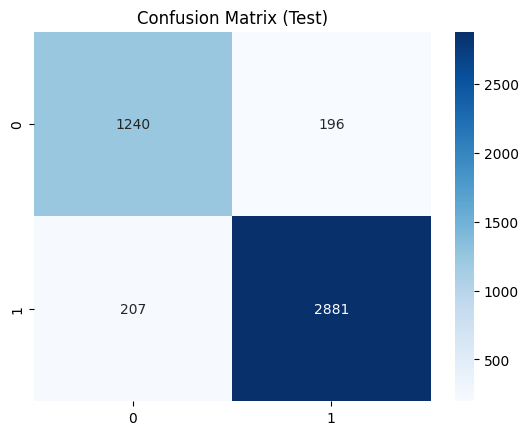

ROC-AUC: 0.9657
Average Precision (AP): 0.9853
Positive class baseline: 0.6826


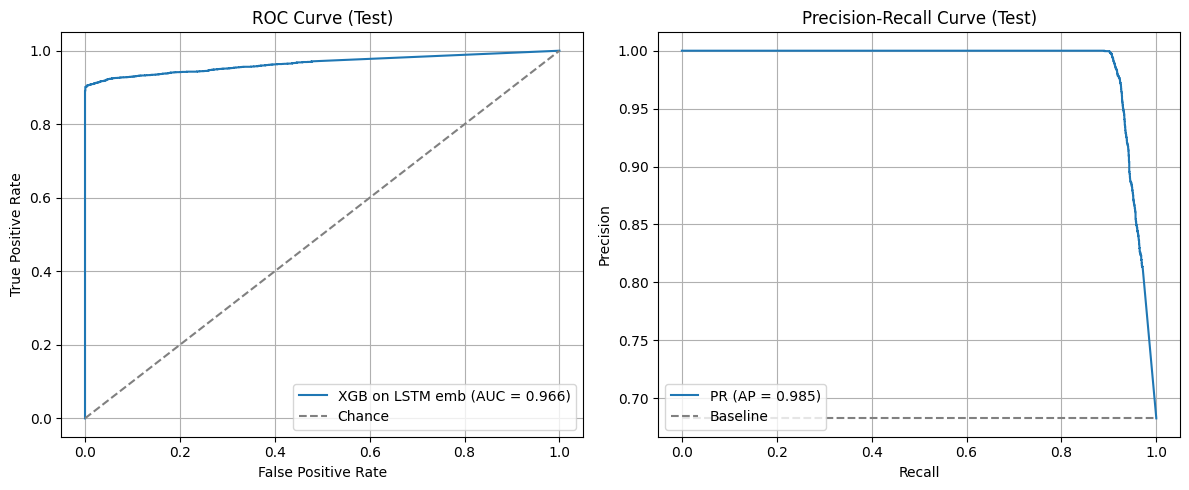

In [ ]:
# Load
X = np.load('/content/drive/MyDrive/diskdata/X_lstm.npy')   # (N, T, F)
y = np.load('/content/drive/MyDrive/diskdata/y_lstm.npy')
dates = np.load('/content/drive/MyDrive/diskdata/dates.npy').astype('datetime64[D]')
disk_ids = np.load('/content/drive/MyDrive/diskdata/disk_ids.npy').astype(str)
assert len(X)==len(y)==len(dates)==len(disk_ids)

# Time division + GAP + device isolation
TEST_SIZE = 0.2
VAL_SIZE  = 0.2
GAP_DAYS = max(X.shape[1], 7)

ts = dates.astype('datetime64[s]').astype('int64')
cutoff = np.datetime64(int(np.quantile(ts, 1-TEST_SIZE)), 's')
gap = np.timedelta64(GAP_DAYS, 'D')

train_mask_time = dates < (cutoff - gap)
test_mask       = dates >= cutoff

test_disks = set(disk_ids[test_mask])
train_mask_device_safe = np.array(
    [m and (disk_ids[i] not in test_disks) for i, m in enumerate(train_mask_time)]
)

idx_all   = np.where(train_mask_device_safe)[0]
disk_tr   = disk_ids[idx_all]
dates_tr  = dates[idx_all]
y_tr      = y[idx_all]

uniq = np.unique(disk_tr)
last_dt = np.empty(len(uniq), dtype='datetime64[D]')
is_pos_disk = np.zeros(len(uniq), dtype=int)
for i, d in enumerate(uniq):
    m = (disk_tr == d)
    last_dt[i] = dates_tr[m].max()
    is_pos_disk[i] = int(y_tr[m].max())

pos_disks = uniq[is_pos_disk == 1]
neg_disks = uniq[is_pos_disk == 0]

def pick_val_disks(disks, last_dt_map, frac, use_time=True, rng_seed=42):
    if len(disks) == 0:
        return set()
    k = max(1, int(np.ceil(len(disks) * frac)))
    if use_time:
        order = np.argsort([last_dt_map[d] for d in disks])
        chosen = [disks[i] for i in order[-k:]]
    else:
        rng = np.random.default_rng(rng_seed)
        chosen = rng.choice(disks, size=k, replace=False)
    return set(chosen)

last_dt_map = {d: last_dt[i] for i, d in enumerate(uniq)}
val_pos = pick_val_disks(pos_disks, last_dt_map, VAL_SIZE, use_time=True)
val_neg = pick_val_disks(neg_disks, last_dt_map, VAL_SIZE, use_time=True)
val_disks = val_pos | val_neg

is_val_disk   = np.array([d in val_disks for d in disk_tr])
is_train_disk = ~is_val_disk

val_mask_final   = np.zeros_like(test_mask, dtype=bool)
train_mask_final = np.zeros_like(test_mask, dtype=bool)
val_mask_final[idx_all[is_val_disk]]     = True
train_mask_final[idx_all[is_train_disk]] = True

assert len(set(disk_ids[train_mask_final]) & set(disk_ids[val_mask_final])) == 0
assert len(set(disk_ids[train_mask_final]) & set(disk_ids[test_mask])) == 0
assert len(set(disk_ids[val_mask_final])   & set(disk_ids[test_mask])) == 0

X_train, y_train = X[train_mask_final], y[train_mask_final]
X_val,   y_val   = X[val_mask_final],   y[val_mask_final]
X_test,  y_test  = X[test_mask],        y[test_mask]

print(f"Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")

# LSTM Model
class DiskDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return torch.tensor(self.X[i], dtype=torch.float32), torch.tensor(self.y[i], dtype=torch.long)

train_loader = DataLoader(DiskDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader   = DataLoader(DiskDataset(X_val,   y_val),   batch_size=256, shuffle=False)

T, F = X_train.shape[1], X_train.shape[2]
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden, 2)
    def forward(self, x):
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :]
        return self.fc(self.dropout(last_hidden))
    def extract_embedding(self, x):
        self.eval()
        with torch.no_grad():
            out, _ = self.lstm(x)
            return out[:, -1, :]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(F).to(device)

counts = np.bincount(y_train)
class_w = (counts.sum() / (counts + 1e-8)).astype(np.float32)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_w, device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Train LSTM
best_f1, best_state, wait = -1, None, 0
for ep in range(1, 30+1):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
    # Val F1
    model.eval()
    v_pred, v_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1).cpu().numpy()
            v_pred.extend(pred)
            v_true.extend(yb.cpu().numpy())
    val_f1 = f1_score(v_true, v_pred)
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_state = {k:v.cpu() for k,v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1
        if wait >= 5: break
print(f"Best Val F1 = {best_f1:.4f}")
model.load_state_dict(best_state)

# Extract Embedding
def get_embeddings(X_data):
    loader = DataLoader(DiskDataset(X_data, np.zeros(len(X_data))), batch_size=256)
    all_emb = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            emb = model.extract_embedding(xb)
            all_emb.append(emb.cpu().numpy())
    return np.vstack(all_emb)

emb_train = get_embeddings(X_train)
emb_val   = get_embeddings(X_val)
emb_test  = get_embeddings(X_test)

dtrain = xgb.DMatrix(emb_train, label=y_train)
dval   = xgb.DMatrix(emb_val,   label=y_val)
dtest  = xgb.DMatrix(emb_test,  label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'eta': 0.1,
    'scale_pos_weight': (y_train==0).sum() / max((y_train==1).sum(),1),
    'random_state': 42
}

bst = xgb.train(params, dtrain, num_boost_round=200, evals=[(dval, 'val')], early_stopping_rounds=20)

y_pred = (bst.predict(dtest) > 0.5).astype(int)
print("\nXGBoost on LSTM embeddings (Test):\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.show()

#  & PR
# Use the early stop to predict the probability
y_prob = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# PR
precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
pos_rate = (y_test == 1).mean()

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision (AP): {ap:.4f}")
print(f"Positive class baseline: {pos_rate:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- ROC ---
axes[0].plot(fpr, tpr, label=f'XGB on LSTM emb (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve (Test)')
axes[0].legend()
axes[0].grid(True)

# --- PR ---
axes[1].plot(recall, precision, label=f'PR (AP = {ap:.3f})')
axes[1].hlines(pos_rate, 0, 1, colors='gray', linestyles='--', label='Baseline')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve (Test)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
